# 7.1 Fashion classification

A convolutional neural network is a special model used for images. These neural networks consist of many layers, and that's why they are often called "deep". Deep learning is a part of machine learning that deals with deep neural networks.

The plan for our project is

- First, we download the dataset and use a pretrained model to classify images.
- Then, we talk about neural networks, and see how they work internally.
- After that, we adjust the pretrained neural network for solving our tasks.
- Finally, we expand our dataset by generating many more images from the images we have.

For evaluating the quality of our models, let’s use accuracy: the percentage of items we classified correctly.

### 7.1.1 GPU vs. CPU

GPU's are usually quicker than CPU's when it comes to computationally demaning processes.

### 7.1.2 Downloading the clothing dataset

The dataset is already split into folders:

- train: 3068 images
- validation: 341 images
- test: 372 images

Each of these folders has 10 subfolders, one for each type of clothing.

With the variety of images that we have, it's not possible to use the methods we know at this point, we need a special type of model. This is where neural networks comes in.

### 7.1.3. TensorFlow and Keras

TensorFlow is a low-level framework, and it’s not always easy to use. In this chapter, we use Keras—a higher-level library built on top of TensorFlow. Keras makes training neural networks a lot simpler. It comes preinstalled together with TensorFlow, so we don’t need to install anything extra.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

### 7.1.4. Images

Keras offers a special function for loading images called load_img. Let’s import it:

In [2]:
from tensorflow.keras.preprocessing.image import load_img

Let's look at one of the images:

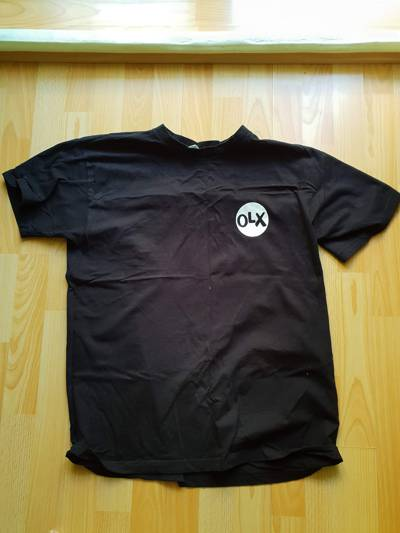

In [3]:
path = "./clothing-dataset-small-master/train/t-shirt/"
name = "5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg"
fullname = path + "/" + name
load_img(fullname)

To use this image in a neural network, we need to resize it because the models always expect images of a certain size. For example, the network we use in this chapter requires a 150 × 150 image or an 299 × 299 image.

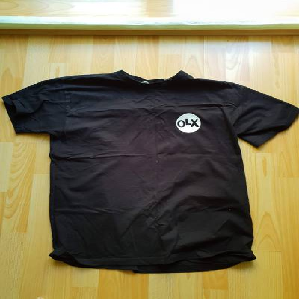

In [4]:
load_img(fullname, target_size=(299, 299))

Let's now use a neural network to classify this image.

## 7.2 Convolutional neural networks

Neural networks are a class of machine learning models for solving classification and regression problems. Our problem is a classification problem because we need to determine the category of an image.

A convolutional neural network can extract visual patterns from an image and use them to make predictions.

### 7.2.1. Using a pretrained model

Training a convolutional neural network from scratch is a time-consuming process and requires a lot of data and powerful hardware. It may take weeks of nonstop training for large datasets like ImageNet with 14 million images.

Luckily, we don’t need to do it ourselves: we can use pretrained models. Usually, these models are trained on ImageNet and can be used for general-purpose image classification.

It’s very simple, and we don’t even need to download anything ourselves—Keras will take care of it automatically. We can use many different types of models (called architectures). You can find a good summary of available pretrained models in the official Keras documentation (https://keras.io/api/applications/).

For this chapter, we’ll use Xception, a relatively small model that has good performance. First, we need to import the model itself and some helpful functions:

In [5]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

We imported three things:

- Xception: the actual model
- preprocess_input: a function for preparing the image to be used by the model
- decode_prediction: a function for decoding the model’s prediction

Let's load this model:

In [6]:
model = Xception(
    weights="imagenet",
    input_shape=(299, 299, 3)
)

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step 


We specify two parameters here:

- weights: We want to use a pretrained model from ImageNet.
- input_shape: The size of the input images: height, width, and the number of channels. We resize the images to 299 x 299, and each image has three channels: red, green and blue.

When we load it for the first time, it downloads the actual model from the internet. After it’s done, we can use it.

Let’s test it on the image we saw previously. First, we load it using the load_img function:

In [7]:
img = load_img(fullname, target_size=(299, 299))

The img variable is an image object, which we need to convert to a NumPy array. It's easy to do:

In [8]:
x = np.array(img)

In [9]:
x.shape

(299, 299, 3)

We see (299, 299, 3) it contains three dimensions:

- The width of the image: 299
- The height of the image: 299
- The number of channels: red, green, blue

This matches the input shape we specified when loading the neural network. However, the model doesn’t expect to get just a single image. It gets a batch of images—several images put together in one array. This array should have four dimensions:

- The number of images
- The width
- The height
- The number of channels

For example, for 10 images, the shape is (10, 299, 299, 3). Because we have just one image, we need to create a batch with this single image:

In [11]:
X = np.array([x])

In [12]:
X.shape

(1, 299, 299, 3)

Before we can apply the model to uor image, we need to prepare it with the preprocess_input function:

In [13]:
X = preprocess_input(X)

This function converts the integers between 0 and 255 in the original array to numbers between -1 and 1.

Now we're ready to use the model.

### 7.2.2. Getting predictions

To apply the model, use the predict method:

In [14]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


In [15]:
pred.shape

(1, 1000)

This Xception model predicts whether an image belongs to one of 1000 clases, so each element in the prediction array is the probability of belonging to one of these classes.

We don't know what these classes are, so it's difficult to make sense from this prediction just by looking at the numbers. Luckily, we can use a function, decode_predictions, that decodes the prediction into meaningful class names:

In [16]:
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


[[('n03595614', 'jersey', np.float32(0.6819626)),
  ('n02916936', 'bulletproof_vest', np.float32(0.03814005)),
  ('n04370456', 'sweatshirt', np.float32(0.0343249)),
  ('n03710637', 'maillot', np.float32(0.01135424)),
  ('n04525038', 'velvet', np.float32(0.0018453642))]]

It shows the top five most likely classes for this image.

Not quite the result we expected. Most likely, images like this T-shirt are not comon in ImageNet, and that's why the result isn't useful for our problem.

Even though these results aren't particularly helpful for us, we can use this neural network as a base model for solving our problem.

To understand how we can do it, we should first get a feeling for how convolutional neural networks work. Let's see what happens inside the model when we invoke the predict method.

## 7.3. Internals of the model

All neural networks are organized in layers. We take an image, pass it through all the layers, and, at the end, get the predictions.

Usually, a model has a lot of layers. For example, the Xception model we use here has 71 layers. That's why these neural networks are called "deep" neural networks - because they have many layers.

For a  convolutional neural network, the most important layers are:

- Convolutional layers
- Dense layers

First, let's take a look at convolutional layers.

### 7.3.1. Convolutional layers

Even though "convolutional layer" sounds complicated, it's nothing more than a set of filters - small "images" with simple shapes like stripes.

The filters in a convolutional layer are learned by the model during training. However, because we are using a pretrained neural network, we don’t need to worry about it; we already have the filters.

To apply a convolutional layer to a picture, we slide each filter acrosss this image.

While sliding, we compare the content of the filter with the content of the image under the filter. For each comparison, we record the degree of similarity. This way, we get a feature map - an array with numbers, where a large number means a match between the filter and the image, and a low number means no match.

So, a feature map tells us where on the image we can find the shape from the filter.

One convolutional layer consists of many filters, so we actually get multiple feature maps - one for each filter.

Now we can take the output of one convolutional layer and use it as the input to the next layer.

From the previous layer we know the location of different stripes and other simple shapes. When two simple shapes occur in the same location, they form more complex patterns - crosses, angles, or circles.

That's what the filters of the next layer do: they combine shapes from the previous layer into more complex structures. The deeper we go down the network, the more complex pattens the network can recognize.

We repeat this process to detect more and more complex shapes. This way, the network "learns" some distinctive features of the image. For clothes, it can be short or long sleeves or the type of neck. For animsls, it can be pointy or floppy ears or the presence of whiskers.

At the end, we get a vector representation of an image: a one-dimensional array, where each position corresponds to some high-level visual features. Some parts othe array may correspond to sleeves, whereas other parts represent ears and whiskers. At this level, it's usually difficult to make sense from these features, but they have enough discriminative power to distinguish between a T-shirt and pants or between a cat and a dog.

Now we need to use this vector representation to combine these high-level features and arrive at the final decision. For that, we use a different kind of layers - dense layers.

### 7.3.2. Dense layers

Dense layers process the vector representation of an image and translate these visual features to the actual class—T-shirt, dress, jacket, or other class.

Convolutional layers transform an image into its vector representation, and dense layers translate the vector representation into the actual label.

To understand how it works, let’s take a step back and think how we could use logistic regression for classifying images.

Suppose we want to build a binary classification model for predicting whether an image is a T-shirt. In this case, the input to logistic regression is the vector representation of an image—a feature vector x.

From chapter 3, we know that to make the prediction, we need to combine the features in x with the weights vector w and then apply the sigmoid function to get the final prediction.

We can show it visually by taking all the components of the vector x and connecting them to the output—the probability of being a T-shirt.

What if we need to make predictions for multiple classes? For example, we may want to know if we have an image of a T-shirt, shirt, or dress. In this case, we can build multiple logistic regressions—one for each class.

By putting together multiple logistic regression models, we just created a small neural network!

To make it visually simpler, we can combine the outputs into one layer—the output layer.

When we have 10 classes we want to predict, we have 10 elements in the output layer. To make a prediction, we look at each element of the output layer and take the one with the highest score.

In this case, we have a network with one layer: the layer that converts the input to the output.

This layer is called a dense layer. It’s “dense” because it connects each element of the input with all the elements of its output. For this reason, these layers are sometimes called “fully connected”.

However, we don’t have to stop at just one output layer. We can add more layers between the input and the final output.

So, when we invoke predict, the image first goes through a series of convolutional layers. This way, we extract the vector representation of this image. Next, this vector representation goes through a series of dense layers, and we get the final prediction.

In this book, we give a simplified and high-level overview of the internals of convolutional neural networks. Many other layers exist in addition to convolutional layers and dense layers. For a more in-depth introduction to this topic, check the CS231n notes (cs231n.github.io/convolutional-networks).

Now let’s get back to code and see how we can adjust a pretrained neural network for our project.

## 7.4. Training the model

Training a convolutional neural network takes a lot of time and requires a lot of data. But there’s a shortcut: we can use transfer learning, an approach where we adapt a pretrained model to our problem.

### 7.4.1. Transfer learning

The difficulty in training usually comes from convolutional layers. To be able to extract a good vector representation from an image, the filters need to learn good patterns. For that, the network has to see many different images—the more, the better. But once we have a good vector representation, training dense layers is relatively easy.

This means that we can take a neural network pretrained on ImageNet and use it for solving our problem. This model has already learned good filters. So, we take this model and keep the convolutional layers, but drop the dense layers and instead train new ones.

In this section, we do exactly that. But before we can start training, we need to get our dataset ready.

### 7.4.2. Loading the data

In previous chapters, we loaded the entire dataset into memory and used it to get X - the matrix with features. With images, it's more difficult: we may not have enough memory to keep all the images.

Keras comes with a solution - ImageDataGenerator. Instead of loading the entire dataset into memory, it loads the images from disk in small batches. Let's use it:

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

We already know that images need to be preprocessed using the preprocess_input function. That's why we need to tell ImageDataGenerator how the data should be prepared.

We have a generator now, so we just need to point it to the directory with the data. For that, use the flow_from_directory method:

In [24]:
image_size = (150, 150)
batch_size = 32

In [25]:
train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small-master/train/",
    target_size=image_size,
    batch_size=batch_size
)

Found 3068 images belonging to 10 classes.


For our initial experiments, we use small images of size 150 × 150. This way, it’s faster to train the model. Also, the small size makes it possible to use a laptop for training.

We have 10 classes of clothing in our dataset, and images of each class are stored in a separate directory. For example, all T-shirts are stored in the t-shirt folder. The generator can use the folder structure to infer the label for each image.

When we execute the cell, it informs us how many images there are in the train dataset and how many classes, 3068 images in 10 classes.

Now we repeat the same process for the validation dataset:

In [26]:
validation_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small-master/validation/",
    target_size=image_size,
    batch_size=batch_size
)

Found 341 images belonging to 10 classes.


Like previously, we use the train dataset for training the model and the validation dataset for selecting the best parameters.

We have loaded the data, and now we’re ready to train a model.

### 7.4.3. Creating the model

First, we need to load the base model - this is the pretrained model that we're using for extracting the vector representation from images. Like previously, we also use Xception, but this time, we include only the part with pretrained convolutional layers. After that, we add our own dense layers.

So let's create the base model:

In [28]:
base_model = Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(150, 150, 3)
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step 


Note the include_top parameter: this way, we explicitly specify that we’re not interested in the dense layers of the pretrained neural network, only in the convolutional layers. In Keras terminology, the “top” is the set of final layers of the network.

We don’t want to train the base model; attempting to do so will destroy all the filters. So, we “freeze” the base model by setting the trainable parameter to False:

In [29]:
base_model.trainable = False

Now let's build the clothing classification model:

In [31]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vector)

model = keras.Model(inputs, outputs)

The way we build the model is called the “functional style.” It may be confusing at first, so let’s take a look at each line individually.

First, we specify the inputs and the size of the arrays we expect:

inputs = keras.Input(shape=(150, 150, 3))

Next, we create the base model:

base = base_model(inputs, training=False)

- Even though base_model is already a model, we use it as a function and give it two parameters - inputs, and training=False
    - The first parameter says what will be the input to base_model. It will come from inputs
    - The second parameter (training=False) is optional and says that we don't want to train the base model
- The result is base, which is a functional component (like base_model) that we can combine with other components. We use it as the input to the next layer:

vector = keras.layers.GlovalAveragePooling2D()(base)

Here, we create a pooling layer — a special construction that allows us to convert the output of a convolutional layer (a 3-D array) into a vector (a 1-D array).

After creating it, we immediately invoke it with base as the argument. This way, we say that the input to this layer comes from base.

This may be a bit confusing because we create a layer and immediately connect it to base. We can rewrite it to make it simpler to understand:

In [32]:
pooling = keras.layers.GlobalAveragePooling2D()
vector = pooling(base)

As a result, we get vector. This is another functional component that we connect to the next layer—a dense layer:

outputs = keras.layers.Dense(10)(vector)

Similarly, we first create the layer, and then connect it to vector. For now, we create a network with only one dense layer. It’s enough to get started.

Now the result is outputs — the final result that we want to get out of the network.

So, in our case, the data comes into inputs and goes out of outputs. We just need to do one final step — wrap both inputs and outputs into a Model class:

model = keras.Model(inputs, outputs)

We need to specify two parameters here:

- What the model will get as input, which is inputs in our case
- What the output of the model is, which is outputs

Let’s take a step back and look at the model definition code again, following the flow of data from inputs to outputs.

The flow of data: an image goes to inputs, then base_model converts it to base, then pooling converts it to vector, and then a dense layer converts it to output. At the end, inputs and outputs go to a Keras model.

To make it easier to visualize, we can think of every line of code as a block, which gets the data from the previous block, transforms it, and passes to the next block.

So, we have created a model that can take in an image, get the vector representation using the base model, and make the final prediction with a dense layer.

Let’s train it now.

### 7.4.4. Training the model

We have specified the model: the input, the elements of the model (the base model, the pooling layer), and the final output layer.

Now we need to train it. For that, we need an optimizer, which adjusts the weights of a network to make it better at doing its task.

We won’t cover the details of how optimizers work—that’s beyond the scope for this book, and it’s not required to finish the project. But if you’d like to learn more about them, check the CS231n notes (https://cs231n.github.io/neural-networks-3/). You can see the list of available optimizers in the official documentation for Keras (https://keras.io/api/optimizers/).

For our project, we will use the Adam optimization algorithm—a good default choice, and in most cases, using it is sufficient.

Let's create it:

In [33]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate)

Adam requires one parameter: the learning rate, which specifies how fast our network learns.

The learning rate may significantly affect the quality of our network. If we set it too high, the network learns too fast and may accidentally skip some important details. In this case, the predictive performance is not optimal. If we set it too low, the network takes too long to train, so the training process is highly ineffective.

We will later adjust this parameter. For now, we set it to 0.01—a good default value to start with.

To train a model, the optimzer needs to know whether the model is doing well. For that, it uses a loss function, which becomes smaller as the network becomes better. The goal of the optimzer is to minimize this loss.

The keras.losses package offers many different losses. Here's a list of the most important ones:

- BinaryCrossentropy: for training a binary classifer
- CategoricalCrossentropy: for training a classification model
- MeanSquaredError: for training a regression model

Because we need to classify clothing into 10 different classes, we use the categorical cross-entropy loss:

In [34]:
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

For this loss, we specify one parameter: from_logits=True. We need to do this because the last layer of our network outputs raw scores (called “logits”), not probabilities. The official documentation recommends doing this for numerical stability (https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy).

Alternatively, we could define the last layer of the network like this:

outputs = keras.layers.Dense(10, activation="softmax")(vector)

In this case, we explicitly tell the network to output probabilities:

softmax is similar to sigmoid but for multiple classes. Then the output is not "logits" anymore, so we can drip the parameter:

In [35]:
loss = keras.losses.CategoricalCrossentropy()

Now let’s put the optimizer and the loss together. For that, we use the compile method of our model:

In [39]:
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In addition to the optimizer and the loss, we also specify metrics we want to track during training. We’re interested in accuracy: the percentage of images with correct predictions.

Our model is ready for training! To do it, use the fit method:

In [40]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - accuracy: 0.4914 - loss: 13.9965 - val_accuracy: 0.7419 - val_loss: 2.6474
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 245ms/step - accuracy: 0.8301 - loss: 1.1383 - val_accuracy: 0.7947 - val_loss: 1.8185
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - accuracy: 0.8854 - loss: 0.5163 - val_accuracy: 0.7683 - val_loss: 1.7917
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step - accuracy: 0.9227 - loss: 0.2802 - val_accuracy: 0.7830 - val_loss: 1.8845
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 267ms/step - accuracy: 0.9236 - loss: 0.2784 - val_accuracy: 0.7742 - val_loss: 1.7008
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - accuracy: 0.9583 - loss: 0.1157 - val_accuracy: 0.8065 - val_loss: 1.5412
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - accuracy: 0.9884 - loss: 0.0309 - val_accuracy: 0.7947 - val_loss: 1.5428
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 262ms/step - accuracy: 0.9951 - loss: 0.0233 - val_acc

We specify three parameters:

- train_ds: The dataset for training
- epochs: The number of times it will go over the training data
- validation_data: The dataset for evaluation

One iteration over the entire training dataset is called an epoch. The more iterations we do, the better the network learns the training dataset.

At some point, it can learn the dataset so well that it starts overfitting. To know when this happens, we need to monitor the performance of our model on the validation dataset. That’s why we specify the validation_data parameter.

When we start training, Keras informs us about the progress:

From that we can see:

- The speed of training: how long each epoch takes.
- The accuracy on the train and validation datasets. We should monitor the accuracy on the validation set to make sure the model doesn’t start overfitting. For example, if the validation accuracy decreases for multiple epochs, it’s a sign of overfitting.
- The loss on training and validation. We’re not interested in loss—it’s less intuitive and the values are harder to interpret.

As you can see, the model quickly becomes 99% accurate on the train dataset, but the score on validation stays around 80% for all the epochs.

The perfect accuracy on the train data doesn’t necessarily mean that our model overfits, but it’s a good sign that we should adjust the learning rate parameter. We have previously mentioned that it’s an important parameter, so let’s tune it now.

### 7.4.5. Adjusting the learning rate

We have started with a learning rate of 0.01. It’s a good starting point, but it’s not necessarily the best rate: we have seen that our model learns too fast and after a few epochs predicts the train set with 100% accuracy.

Let’s experiment and try other values for this parameter.

First, to make it easier, we should put the logic for model creating in a separate function. This function takes learning rate as a parameter.

In [41]:
def make_model(learning_rate):
    base_model = Xception(
        weights="imagenet",
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

We’ve tried 0.01, so let’s try 0.001:

In [42]:
model = make_model(learning_rate=0.001)
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step - accuracy: 0.4948 - loss: 1.5005 - val_accuracy: 0.7742 - val_loss: 0.7383
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step - accuracy: 0.7691 - loss: 0.6601 - val_accuracy: 0.7947 - val_loss: 0.6321
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.8319 - loss: 0.5091 - val_accuracy: 0.8035 - val_loss: 0.5924
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.8679 - loss: 0.4226 - val_accuracy: 0.8152 - val_loss: 0.5548
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.8888 - loss: 0.3662 - val_accuracy: 0.8065 - val_loss: 0.5643
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 237ms/step - accuracy: 0.8985 - loss: 0.3477 - val_accuracy: 0.8035 - val_loss: 0.5640
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.9283 - loss: 0.2864 - val_accuracy: 0.8123 - val_loss: 0.5433
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.9406 - loss: 0.2477 - val_accu

We can also try an even smaller value of 0.0001:

In [43]:
model = make_model(learning_rate=0.0001)
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 275ms/step - accuracy: 0.1820 - loss: 2.2842 - val_accuracy: 0.4663 - val_loss: 1.6586
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step - accuracy: 0.4971 - loss: 1.5066 - val_accuracy: 0.6070 - val_loss: 1.2852
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.5932 - loss: 1.2278 - val_accuracy: 0.6745 - val_loss: 1.0914
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - accuracy: 0.6530 - loss: 1.0643 - val_accuracy: 0.7009 - val_loss: 0.9738
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - accuracy: 0.6934 - loss: 0.9360 - val_accuracy: 0.7302 - val_loss: 0.8961
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 244ms/step - accuracy: 0.7190 - loss: 0.8592 - val_accuracy: 0.7537 - val_loss: 0.8419
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - accuracy: 0.7395 - loss: 0.8120 - val_accuracy: 0.7654 - val_loss: 0.7969
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - accuracy: 0.7534 - loss: 0.7603 - val_accu

As we see, for 0.001, the training accuracy doesn’t go up as fast as with 0.01, but with 0.0001 it goes up very slowly. The network in this case learns too slow—it underfits.

If we look at validation scores for all the learning rates, we see that the learning rate of 0.001 is the best one.

For the learning rate of 0.001, the best accuracy is 81.8%.

The difference between 0.01 and 0.001 is not significant. But if we look at the accuracy on the training data, with 0.01, it overfits the training data a lot faster. At some point, it even achieves an accuracy of 100%. When the discrepancy between the performance on train and validation sets is high, the risk of overfitting is also high. So, we should prefer the learning rate of 0.001.

After training is done, we need to save the model. Now we’ll see how to do it.

### 7.4.6. Saving the model and checkpointing

Once the model is trained, we can save it using the save_weights method:

In [48]:
model.save_weights("xception_v1_model.weights.h5")

You may have noticed that while training, the performance of our model on the validation set jumps up and down. This way, after 10 iterations, we don’t necessarily have the best model—maybe the best performance was achieved on iteration 5 or 6.

We can save the model after each iteration, but it generates too much data. And if we rent a server in the cloud, it can quickly take all the available space.

Instead, we can save the model only when it’s better than the previous best score on validation. For example, if the previous best accuracy is 0.8, but we have improved it to 0.91, we save the model. Otherwise, we continue the training process without saving the model.

This process is called model checkpointing. Keras has a special class for doing it: ModelCheckpoint. Let’s use it:

In [49]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy"
)

In [50]:
model = make_model(learning_rate=0.001)
 
model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5273 - loss: 1.4244 

96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.5285 - loss: 1.4207 - val_accuracy: 0.7830 - val_loss: 0.6989
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7874 - loss: 0.6344 

96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.7874 - loss: 0.6344 - val_accuracy: 0.8152 - val_loss: 0.6088
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8365 - loss: 0.5056 

96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - accuracy: 0.8364 - loss: 0.5056 - val_accuracy: 0.8182 - val_loss: 0.5653
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.8734 - loss: 0.4240 - val_accuracy: 0.7977 - val_loss: 0.5742
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8975 - loss: 0.3516 

96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - accuracy: 0.8974 - loss: 0.3517 - val_accuracy: 0.8358 - val_loss: 0.5446
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - accuracy: 0.9109 - loss: 0.3089 - val_accuracy: 0.8240 - val_loss: 0.5265
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - accuracy: 0.9270 - loss: 0.2749 - val_accuracy: 0.8299 - val_loss: 0.5295
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - accuracy: 0.9288 - loss: 0.2696 - val_accuracy: 0.8299 - val_loss: 0.5262
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.9459 - loss: 0.2232 - val_accuracy: 0.8270 - val_loss: 0.5256
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.9488 - loss: 0.2094 - val_accuracy: 0.8240 - val_loss: 0.5386


We’ve learned how to store the best model. Now let’s improve our model by adding more layers to the network.

### 7.4.7 Adding more layers

Previously, we trained a model with one dense layer:

We don’t have to restrict ourselves to just one layer, so let’s add another layer between the base model and the last layer with predictions.

For example, we can add a dense layer of size 100:

In [51]:
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)
 
inner = keras.layers.Dense(100, activation="relu")(vector)
 
outputs = keras.layers.Dense(10)(inner)
 
model = keras.Model(inputs, outputs)

There’s no particular reason for selecting the size of 100 for the inner dense layer. We should treat it as a parameter: as with the learning rate, we can try different values and see which one leads to better performance on validation. In this chapter, we will not experiment with changing the size of the inner layer, but feel free to do so.

This way, we added a layer between the base model and the outputs.

Here, we set the activation parameter to relu.

Remember that we get a neural network by putting together multiple logistic regressions. In logistic regression, sigmoid is used for converting the raw score to probability. But for inner layers, we don’t need probabilities, and we can replace sigmoid with other functions. These functions are called activation functions. ReLU (Rectified Linear Unit) is one of them, and for inner layers, it’s a better choice than sigmoid.

The sigmoid function suffers from the vanishing gradient problem, which makes training deep neural networks impossible. ReLU solves this problem. To read more about this problem, and about activation functions in general, please refer to the CS231n notes (https://cs231n.github.io/neural-networks-1/).

With another layer, our chances of overfitting increase significantly. To avoid that, we need to add regularization to our model. Next, we’ll see how to do it.

### 7.4.8 Regularization and dropout

Dropout is a special technique for fighting overfitting in neural networks. The main idea behind dropout is freezing a part of a dense layer when training. At each iteration, the part to freeze is chosen randomly. Only the unfrozen part is trained, and the frozen part is not touched at all.

If some parts of the network are ignored, the model overall is less likely to overfit. When the network goes over a batch of images, the frozen part of a layer doesn’t see this data—it’s turned off. This way, it’s more difficult for the network to memorize the images.

For every batch, the part to freeze is selected randomly, so the network learns to extract patterns from incomplete information, which makes it more robust and less likely to overfit.

We can control the strength of dropout by setting the dropout rate—the fraction of elements in a layer to be frozen at each step.

To do this in Keras, we add a Dropout layer after the first Dense layer and set up the dropout rate:

In [52]:
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)
 
inner = keras.layers.Dense(100, activation="relu")(vector)
drop = keras.layers.Dropout(0.2)(inner)
outputs = keras.layers.Dense(10)(drop)
 
model = keras.Model(inputs, outputs)

This way, we add another block in the network—the dropout block.

Let’s train this model. To make it easier, we first need to update the make_model function and add another parameter there for controlling the dropout rate.

In [53]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights="imagenet",
        input_shape=(150, 150, 3),
        include_top=False
    )
 
    base_model.trainable = False
 
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
 
    inner = keras.layers.Dense(100, activation="relu")(vector)
    drop = keras.layers.Dropout(droprate)(inner)
 
    outputs = keras.layers.Dense(10)(drop)
 
    model = keras.Model(inputs, outputs)
 
    optimizer = keras.optimizers.Adam(learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
   
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"],
    )
   
    return model

Let’s try four different values for the droprate parameter to see how the performance of our model changes:

- 0.0: Nothing gets frozen, so this is equivalent to not including the dropout layer at all.
- 0.2: Only 20% of the layer gets frozen,
- 0.5: Half of the layer is frozen.
- 0.8: Most of the layer (80%) is frozen.

With dropout, it takes more time to train a model: at each step, only a part of our network learns, so we need to make more steps. This means that we should increase the number of epochs when training.

So, let’s train it:

In [54]:
model = make_model(learning_rate=0.001, droprate=0.0)
model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step - accuracy: 0.5752 - loss: 1.2876 - val_accuracy: 0.7771 - val_loss: 0.6562
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 237ms/step - accuracy: 0.8129 - loss: 0.5083 - val_accuracy: 0.7742 - val_loss: 0.6654
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.8861 - loss: 0.3526 - val_accuracy: 0.8123 - val_loss: 0.5553
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.9294 - loss: 0.2554 - val_accuracy: 0.7713 - val_loss: 0.6480
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 251ms/step - accuracy: 0.9560 - loss: 0.1819 - val_accuracy: 0.8182 - val_loss: 0.5525
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 264ms/step - accuracy: 0.9777 - loss: 0.1175 - val_accuracy: 0.8094 - val_loss: 0.5707
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.9828 - loss: 0.0892 - val_accuracy: 0.8328 - val_loss: 0.5767
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.9957 - loss: 0.0572 - val_accu

When it finishes, repeat this for other values of the droprate parameter by copying the code to another cell and changing the value to 0.2, 0.5, and 0.8.

From the results on the validation dataset, we see that there’s no significant difference between 0.0, 0.2, and 0.5. However, 0.8 is worse—we made it really difficult for the network to learn anything.

The best accuracy the textbook achieved was 84.5% for the dropout rate of 0.5.

In cases like this, when there’s no visible difference between accuracy on the validation dataset, it’s useful to look at the accuracy on the train set as well.

With no dropout, the model quickly memorizes the entire train dataset, and after 10 epochs, it becomes 99.9% accurate. With a dropout rate of 0.2, it needs more time to overfit the training dataset, whereas for 0.5, it hasn’t reached the perfect accuracy, even after 30 iterations. By setting the rate to 0.8, we make it really difficult for the network to learn anything, so the accuracy is low even on the training dataset.

We can see that with a dropout rate of 0.5, the network doesn’t overfit as fast as others, while maintaining the same level of accuracy on the validation dataset as 0.0 and 0.2. Thus, we should prefer the model we trained with the dropout rate of 0.5 to other models.

By adding another layer and dropout, we have increased the accuracy from 83% to 84%. Even though this increase is not significant for this particular case, dropout is a powerful tool for fighting overfitting, and we should use it when making our models more complex.

In addition to dropout, we can use other ways to fight overfitting. For example, we can generate more data. In the next section, we’ll see how to do it.

### 7.4.9 Data augmentation

Getting more data is always a good idea, and it’s usually the best thing we can do to improve the quality of our model. Unfortunately, it’s not always possible to get more data.

For images, however, we can generate more data from existing images. For example:

- Flip an image vertically and horizontally.
- Rotate an image.
- Zoom in or out a bit.
- Change an image in other ways.

The process of generating more data from an existing dataset is called data augmentation.

The easiest way to create a new image from an existing one is to flip it horizontally, vertically, or both.

In our case, horizontal flipping might not make much sense, but vertical flipping should be useful.

Rotating is another image-manipulation strategy that we can use: we can generate a new image by rotating an existing one by some degree.

Shear is another possible transformation. It skews the image by “pulling” it by one of its sides. When the shear is positive, we pull the right side down, and when it’s negative, we pull the right side up.

At first glance, the effect of shear and rotation may look similar, but actually, they are quite different. Shear changes the geometrical shape of an image, but rotation doesn’t: it only rotates an image.

Next, we can shift an image horizontally or vertically.

Finally, we can zoom an image in or out.

What is more, we can combine multiple data augmentation strategies. For example, we can take an image, flip it horizontally, zoom out, and then rotate it.

By applying different augmentations to the same image, we can generate many more new images.

Keras provides a built-in way of augmenting a dataset. It’s based on ImageDataGenerator, which we have already used for reading the images.

The generator takes in many arguments. Previously, we used only preprocessing_ function—it’s needed to preprocess the images. Others are available, and many of them are responsible for augmenting the dataset.

For example, we can create a new generator:

In [55]:
train_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=30.0,
    height_shift_range=30.0,
    shear_range=10.0,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input
)

For our project, let’s take a small set of these augmentations:

In [56]:
train_gen = ImageDataGenerator(
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
)

Next, we use the generator in the same way as previously:

In [59]:
train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small-master/train/",
    target_size=(150, 150),
    batch_size=32,
)

Found 3068 images belonging to 10 classes.


We need to apply augmentations only to training data. We don’t use it for validation: we want to make our evaluation consistent and be able to compare a model trained on the augmented dataset with a model trained without augmentations.

So, we load the validation dataset using exactly the same code as before:

In [61]:
validation_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
 
val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small-master/validation",
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


We’re ready to train a new model now:

In [62]:
model = make_model(learning_rate=0.001, droprate=0.2)
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


/opt/homebrew/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - accuracy: 0.5262 - loss: 1.4493 - val_accuracy: 0.7713 - val_loss: 0.6962
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - accuracy: 0.7562 - loss: 0.7343 - val_accuracy: 0.7889 - val_loss: 0.6218
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 266ms/step - accuracy: 0.7986 - loss: 0.5843 - val_accuracy: 0.8211 - val_loss: 0.5597
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 252ms/step - accuracy: 0.8223 - loss: 0.5101 - val_accuracy: 0.8152 - val_loss: 0.5498
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 261ms/step - accuracy: 0.8514 - loss: 0.4514 - val_accuracy: 0.8094 - val_loss: 0.5470
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - accuracy: 0.8506 - loss: 0.4172 - val_accuracy: 0.8006 - val_loss: 0.6717
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - accuracy: 0.8684 - loss: 0.4015 - val_accuracy: 0.8123 - val_loss: 0.5722
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.8802 - loss: 0.3415 - val_accuracy: 0.824

To train this model, we need even more epochs than previously. Data augmentation is also a regularization strategy. Instead of training on the same image over and over again, the network sees a different variation of the same image for every epoch. This makes it more difficult for the model to memorize the data, and it decreases the chances of overfitting.

After training this model, we managed to improve the accuracy by 1%, from 84% to 85%.

This improvement is not really significant. But we have experimented a lot, and we could do this relatively quickly because we used small images of size 150 × 150. Now we can apply everything we have learned so far to larger images.

### 7.4.10 Training a larger model

Even for people it may be challenging to understand what kind of item is in a small 150 × 150 image. It’s also difficult for a computer: it’s not easy to see the important details, so the model may confuse pants and shorts or T-shirts and shirts.

By increasing the size of images from 150 × 150 to 299 × 299, it’ll be easier for the network to see more details and, therefore, achieve greater accuracy.

Training a model on larger images takes approximately four times longer than on small images. If you don’t have access to a computer with a GPU, you don’t have to run the code in this section. Conceptually, the process is the same, and the only difference is the input size.

So, let’s modify our function for creating a model. For that, we need to take the code of make_model and adjust it in two places:

- The input_shape argument of Xception
- The C argument for input

In both these cases, we need to replace (150, 150, 3) with (299, 299, 3).

Next, we need to adjust the target_size parameter for the train and validation generators. We replace (150, 150) by (299, 299), and everything else stays the same.

Now we’re ready to train a model!

In [63]:
model = make_model(learning_rate=0.001, droprate=0.2)
model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 252ms/step - accuracy: 0.5405 - loss: 1.3924 - val_accuracy: 0.7683 - val_loss: 0.6915
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.7692 - loss: 0.6884 - val_accuracy: 0.7742 - val_loss: 0.6785
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 251ms/step - accuracy: 0.8092 - loss: 0.5652 - val_accuracy: 0.8006 - val_loss: 0.5787
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - accuracy: 0.8275 - loss: 0.4775 - val_accuracy: 0.7947 - val_loss: 0.5719
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - accuracy: 0.8534 - loss: 0.4343 - val_accuracy: 0.7859 - val_loss: 0.5842
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - accuracy: 0.8550 - loss: 0.3963 - val_accuracy: 0.8006 - val_loss: 0.5794
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 245ms/step - accuracy: 0.8802 - loss: 0.3527 - val_accuracy: 0.7947 - val_loss: 0.5853
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 260ms/step - accuracy: 0.8875 - loss: 0.3102 - val_accu

This model achieves accuracy of around 89% on the validation data. This is a considerable improvement over the previous model.

We have trained a model, so now it’s time to use it.

## 7.5. Using the model

Previously, we trained multiple models. The best one is the model we trained on large images—it has 89% accuracy. The second-best model has an accuracy of 85%.

Let’s now use these models to make predictions. To use a model, we first need to load it.

### 7.5.1. Loading the model

You can either use the model you trained yourself or download the model we trained for the book and use it.

To download them, go to the releases section of the book’s GitHub repository and look for Models for Chapter 7: Deep learning (figure 7.45). Alternatively, go to this URL: https://github.com/alexeygrigorev/mlbookcamp-code/releases/tag/chapter7-model.

Then download the large model trained on 299 × 299 images (xception_v4_large). To use it, load the model using the load_model function from the models package:

In [64]:
model = keras.models.load_model('xception_v4_large_08_0.894.h5')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'xception_v4_large_08_0.894.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

We have already used both the train and validation datasets. We have finished the training process, so now it’s time to evaluate this model on test data.

### 7.5.2. Evaluating the model

To load the test data, we follow the same approach: we use ImageDataGenerator but point to the test directory. Let’s do it:

In [ ]:
test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
 
test_ds = test_gen.flow_from_directory(
    "clothing-dataset-small-master/test",
    shuffle=False,
    target_size=(299, 299),
    batch_size=32,
)

Evaluating a model in Keras is as simple as invoking the evaluate method:

In [ ]:
model.evaluate(test_ds)

It applies the model to all the data in the test folder and shows the evaluation metrics of loss and accuracy.

Our model shows 90% accuracy on the test dataset, which is comparable with the performance on the validation dataset (89%).

If we repeat the same process for the small dataset, we see that the performance is worse.

The accuracy is 82%, whereas on the validation it’s 85%. The model performed worse on the test dataset.

It may be because of random fluctuations: the size of validation and test sets are not large, only 300 examples. So the model could get lucky on validation and unlucky on test.

However, it could be a sign of overfitting. By repeatedly evaluating the model on the validation dataset, we picked the model that got very lucky. Maybe this luck is not generalizable, and that’s why the model performs worse on the data it hasn’t seen previously.

Now let’s see how we can apply the model to individual images to get predictions.

### 7.5.3. Getting the predictions

If we want to apply the model to a single image, we need to do the same thing ImageDataGenerator performs internally:

- Load an image.
- Preprocess it.

We already know how to load an image. We can use load_img for that:

In [ ]:
path = 'clothing-dataset-small-master/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'
img = load_img(path, target_size=(299, 299))

It’s a picture of pants.

Next, we preprocess the image:

In [ ]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

And, finally, we get the predictions:

In [ ]:
pred = model.predict(X)

We can see the predictions for the image by checking the first row of predictions: pred[0].

The result is an array with 10 elements, where each element contains the score. The higher the score, the more likely the image is to belong to the respective class.

To get the element with the highest score, we can use the argmax method. It returns the index of the element with the highest score.

To know which label corresponds to class 4, we need to get the mapping. It can be extracted from a data generator. But let’s put it manually to a dictionary:

In [ ]:
labels = {
    0: 'dress',
    1: 'hat',
    2: 'longsleeve',
    3: 'outwear',
    4: 'pants',
    5: 'shirt',
    6: 'shoes',
    7: 'shorts',
    8: 'skirt',
    9: 't-shirt'
}

To get the label, simply look it up in the dictionary:

In [ ]:
labels[pred[0].argmax()]

As we see, the label is “pants,” which is correct. Also note that the label “shorts” has a high positive score: pants and shorts are quite similar visually. But “pants” is clearly the winner.

We will use this code in the next chapter, where we will productionize our model.

Exercises:

- 7.1 = a
- 7.2 = b
- 7.3 = d